In [1]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Set memory growth to True to allocate memory as needed
            tf.config.experimental.set_memory_growth(gpu, True)
            # Set a memory limit of 10GB (10240MB)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
    except RuntimeError as e:
        print(e)


In [2]:
# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# List all physical devices
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Check if TensorFlow is using the GPU
if gpus:
    print("Number of GPUs available: ", len(gpus))
    for gpu in gpus:
        print("GPU:", gpu)

    # Perform a simple computation on the GPU
    with tf.device('/GPU:0'):
        a = tf.constant(2.0)
        b = tf.constant(3.0)
        c = a * b
        print(f"Result of computation on GPU: {c.numpy()}")
else:
    print("No GPU found")


TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs available:  1
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Result of computation on GPU: 6.0


# Get the Data

In [3]:
train_dir = "D:\\Wikiart_splitted\\train"
test_dir = "D:\\Wikiart_splitted\\test"
val_dir= "D:\\Wikiart_splitted\\val"

# Import necessary libraries and modules

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [6]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Prep the data

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_height = 299  # Xception model requires 299x299 images
img_width = 299


# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed  # Seed for reproducibility
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Ensure consistent order
    seed=random_seed  # Seed for reproducibility
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Ensure consistent order
    seed=random_seed  # Seed for reproducibility
)


Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model 1_a: SGD as the optimiser

In [14]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 25 layers
for layer in base_model.layers[:-25]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

# Model training

In [15]:
checkpoint = ModelCheckpoint('Model1_a.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 2.8261 - accuracy: 0.1280
Epoch 1: val_accuracy improved from -inf to 0.18130, saving model to Model1_a.h5
1899/1899 [==============================] - 1318s 693ms/step - loss: 2.8261 - accuracy: 0.1280 - val_loss: 2.7070 - val_accuracy: 0.1813
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 2.6608 - accuracy: 0.1806
Epoch 2: val_accuracy improved from 0.18130 to 0.19225, saving model to Model1_a.h5
1899/1899 [==============================] - 1322s 696ms/step - loss: 2.6608 - accuracy: 0.1806 - val_loss: 2.6022 - val_accuracy: 0.1922
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 2.5908 - accuracy: 0.1881
Epoch 3: val_accuracy improved from 0.19225 to 0.19831, saving model to Model1_a.h5
1899/1899 [==============================] - 1299s 684ms/step - loss: 2.5908 - accuracy: 0.1881 - val_loss: 2.5518 - val_accuracy: 0.1983
Epoch 4/10
1899/1899 [=====================

In [16]:
model.save('1a.h5')

# Evaluate the model

In [19]:
model.load_weights('Model1_a.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 82s 343ms/step - loss: 2.3930 - accuracy: 0.2439
Test accuracy: 0.24393460154533386


# Plot accuracy and loss graphs

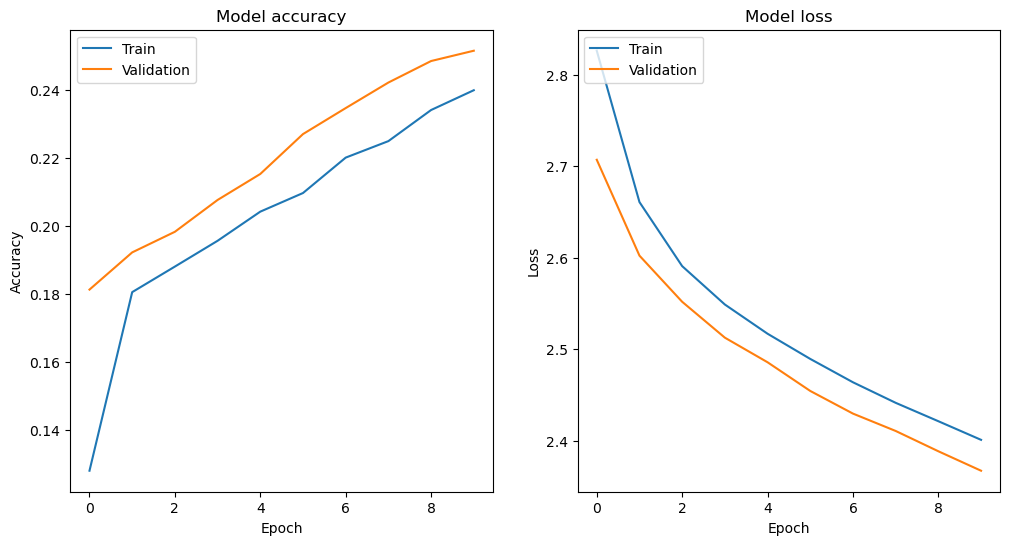

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Plot confusion matrix and classification metrics

Found 7596 images belonging to 19 classes.
238/238 [==============================] - 76s 316ms/step


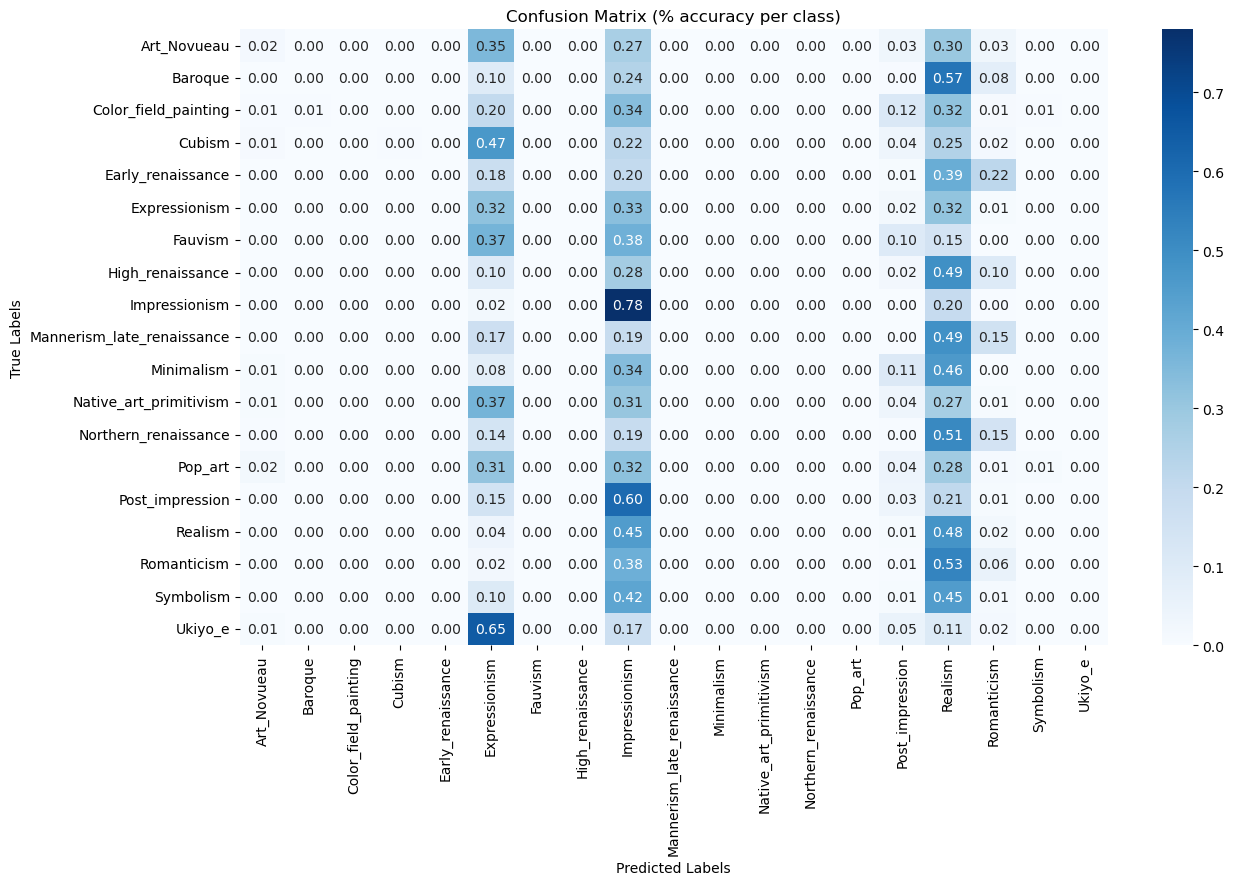

                            precision    recall  f1-score   support

               Art_Novueau       0.30      0.02      0.03       413
                   Baroque       0.33      0.00      0.00       418
      Color_field_painting       0.00      0.00      0.00       182
                    Cubism       1.00      0.00      0.01       261
         Early_renaissance       0.00      0.00      0.00       157
             Expressionism       0.18      0.32      0.23       659
                   Fauvism       0.00      0.00      0.00        89
          High_renaissance       0.00      0.00      0.00       126
             Impressionism       0.31      0.78      0.44      1314
Mannerism_late_renaissance       0.00      0.00      0.00       137
                Minimalism       0.00      0.00      0.00       147
    Native_art_primitivism       0.00      0.00      0.00       278
      Northern_renaissance       0.00      0.00      0.00       240
                   Pop_art       0.00      0.00

C:\Users\PRANAV\.conda\envs\tf_05\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PRANAV\.conda\envs\tf_05\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PRANAV\.conda\envs\tf_05\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
# Path to saved model
model_path = "C:\\Users\\PRANAV\\Downloads\\Model1_a.h5"
model = load_model(model_path)

# Assuming test data is in a directory 'test_data_directory'
test_data_directory = "D:\\Wikiart_splitted\\test"

batch_size = 32
image_height = 299
image_width = 299

# ImageDataGenerator for preprocessing and loading test images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(image_height, image_width), 
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class labels from the generator

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (% accuracy per class)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Model 1_b: Adam with BN, Dropout layers

# Prepare the data

In [22]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)


batch_size = 32
img_height = 299  # Xception model requires 299x299 images
img_width = 299

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model building

In [27]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 25 layers
for layer in base_model.layers[:-25]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

# Model training

In [28]:
checkpoint = ModelCheckpoint('Model1_b.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 1.7507 - accuracy: 0.4377
Epoch 1: val_accuracy improved from -inf to 0.56461, saving model to Model1_b.h5
1899/1899 [==============================] - 1332s 700ms/step - loss: 1.7507 - accuracy: 0.4377 - val_loss: 1.2810 - val_accuracy: 0.5646
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 1.2666 - accuracy: 0.5688
Epoch 2: val_accuracy improved from 0.56461 to 0.59335, saving model to Model1_b.h5
1899/1899 [==============================] - 1334s 702ms/step - loss: 1.2666 - accuracy: 0.5688 - val_loss: 1.1717 - val_accuracy: 0.5934
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 1.0634 - accuracy: 0.6360
Epoch 3: val_accuracy improved from 0.59335 to 0.62012, saving model to Model1_b.h5
1899/1899 [==============================] - 1330s 700ms/step - loss: 1.0634 - accuracy: 0.6360 - val_loss: 1.1220 - val_accuracy: 0.6201
Epoch 4/10
1899/1899 [=====================

In [29]:
model.save('1_b.h5')

# Evaluate the model

In [31]:
model.load_weights('Model1_b.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 82s 343ms/step - loss: 1.1471 - accuracy: 0.6350
Test accuracy: 0.6350210905075073


# Plot accuracy and loss graphs

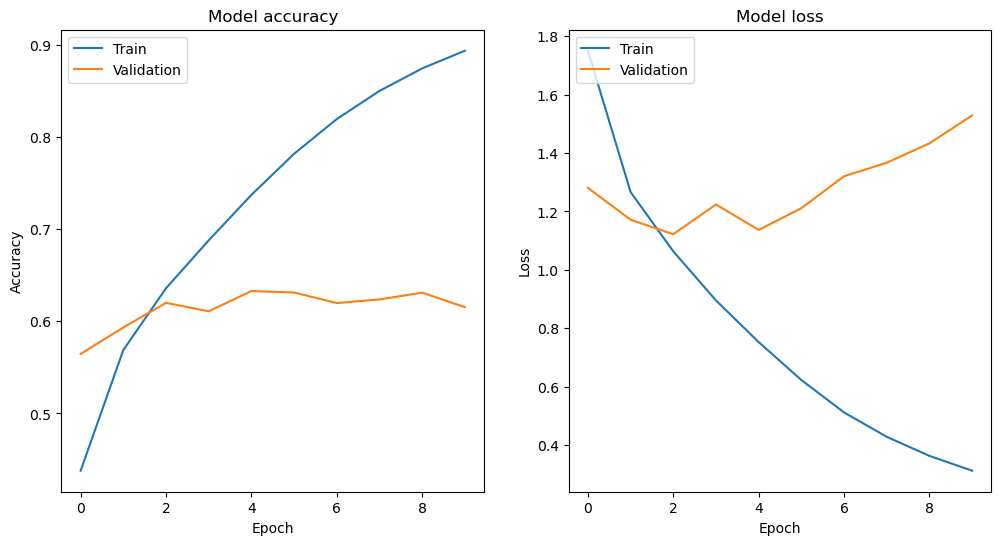

In [33]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Plot confusion matrix and classifcation metrics

Found 7596 images belonging to 19 classes.
238/238 [==============================] - 77s 322ms/step


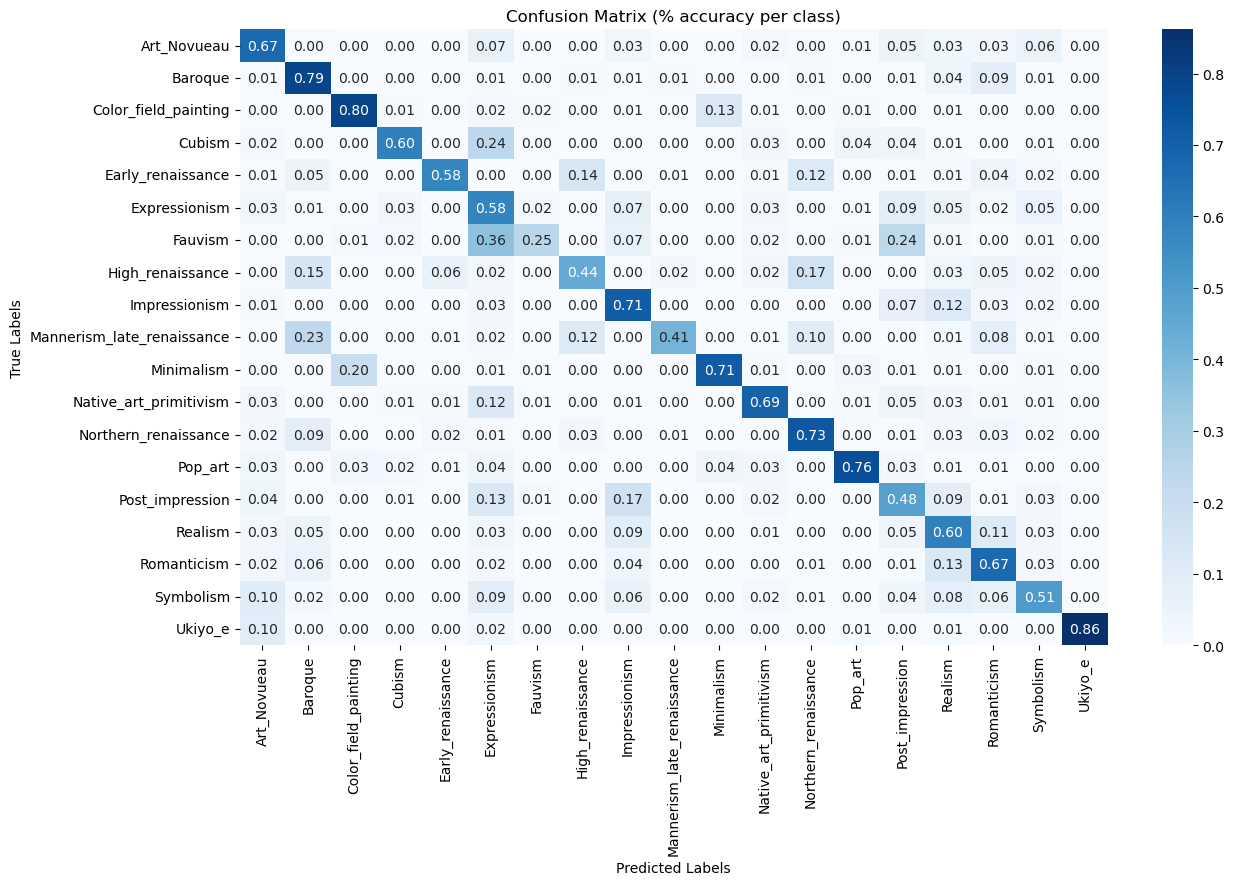

                            precision    recall  f1-score   support

               Art_Novueau       0.59      0.67      0.63       413
                   Baroque       0.62      0.79      0.70       418
      Color_field_painting       0.79      0.80      0.79       182
                    Cubism       0.79      0.60      0.68       261
         Early_renaissance       0.81      0.58      0.67       157
             Expressionism       0.50      0.58      0.54       659
                   Fauvism       0.42      0.25      0.31        89
          High_renaissance       0.50      0.44      0.47       126
             Impressionism       0.73      0.71      0.72      1314
Mannerism_late_renaissance       0.78      0.41      0.54       137
                Minimalism       0.77      0.71      0.74       147
    Native_art_primitivism       0.69      0.69      0.69       278
      Northern_renaissance       0.69      0.73      0.71       240
                   Pop_art       0.75      0.76

In [6]:
# Path to saved model
model_path = "C:\\Users\\PRANAV\\Downloads\\Model1_b.h5"
model = load_model(model_path)

# Assuming test data is in a directory 'test_data_directory'
test_data_directory = "D:\\Wikiart_splitted\\test"

batch_size = 32
image_height = 299
image_width = 299

# ImageDataGenerator for preprocessing and loading test images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(image_height, image_width), 
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class labels from the generator

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (% accuracy per class)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Model 1_c: Batch size =16, Adam

# Prepare the data

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_height = 299  # Xception model requires 299x299 images
img_width = 299


# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed  # Seed for reproducibility
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Ensure consistent order
    seed=random_seed  # Seed for reproducibility
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Ensure consistent order
    seed=random_seed  # Seed for reproducibility
)


Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model Building

In [9]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 25 layers
for layer in base_model.layers[:-25]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

# Model training

In [10]:
checkpoint = ModelCheckpoint('Model1_c.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
3798/3798 [==============================] - ETA: 0s - loss: 1.7536 - accuracy: 0.4366
Epoch 1: val_accuracy improved from -inf to 0.56224, saving model to Model1_c.h5
3798/3798 [==============================] - 1345s 353ms/step - loss: 1.7536 - accuracy: 0.4366 - val_loss: 1.2879 - val_accuracy: 0.5622
Epoch 2/10
3798/3798 [==============================] - ETA: 0s - loss: 1.2835 - accuracy: 0.5650
Epoch 2: val_accuracy improved from 0.56224 to 0.59823, saving model to Model1_c.h5
3798/3798 [==============================] - 1311s 345ms/step - loss: 1.2835 - accuracy: 0.5650 - val_loss: 1.1764 - val_accuracy: 0.5982
Epoch 3/10
3798/3798 [==============================] - ETA: 0s - loss: 1.0854 - accuracy: 0.6278
Epoch 3: val_accuracy improved from 0.59823 to 0.62685, saving model to Model1_c.h5
3798/3798 [==============================] - 1297s 342ms/step - loss: 1.0854 - accuracy: 0.6278 - val_loss: 1.1086 - val_accuracy: 0.6268
Epoch 4/10
3798/3798 [=====================

# Evaluate the model

In [11]:
model.load_weights('Model1_c.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


474/474 [==============================] - 79s 167ms/step - loss: 1.3339 - accuracy: 0.6353
Test accuracy: 0.6352847814559937


# Plot accuracy and loss graphs

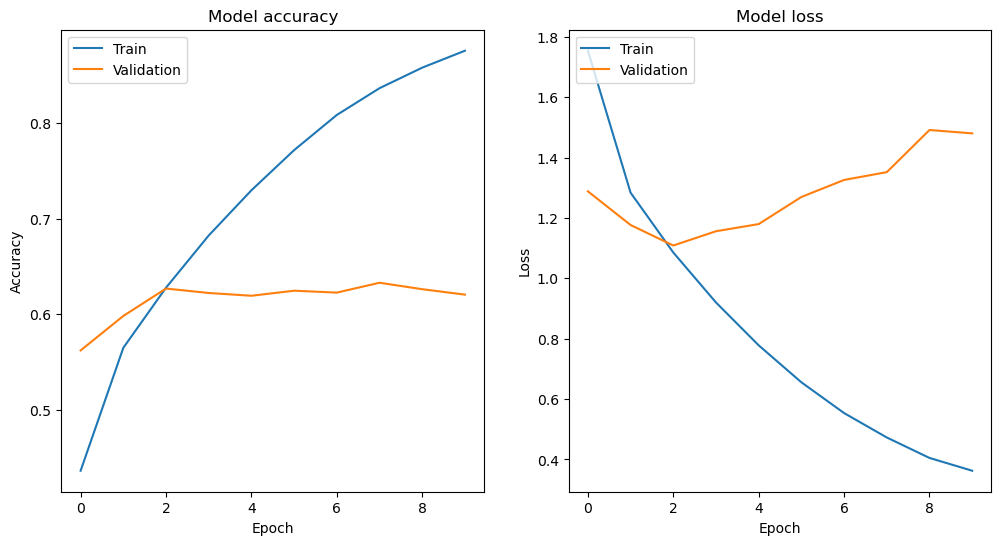

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Plot confusion matrix and classification metrics

Found 7596 images belonging to 19 classes.
238/238 [==============================] - 76s 314ms/step


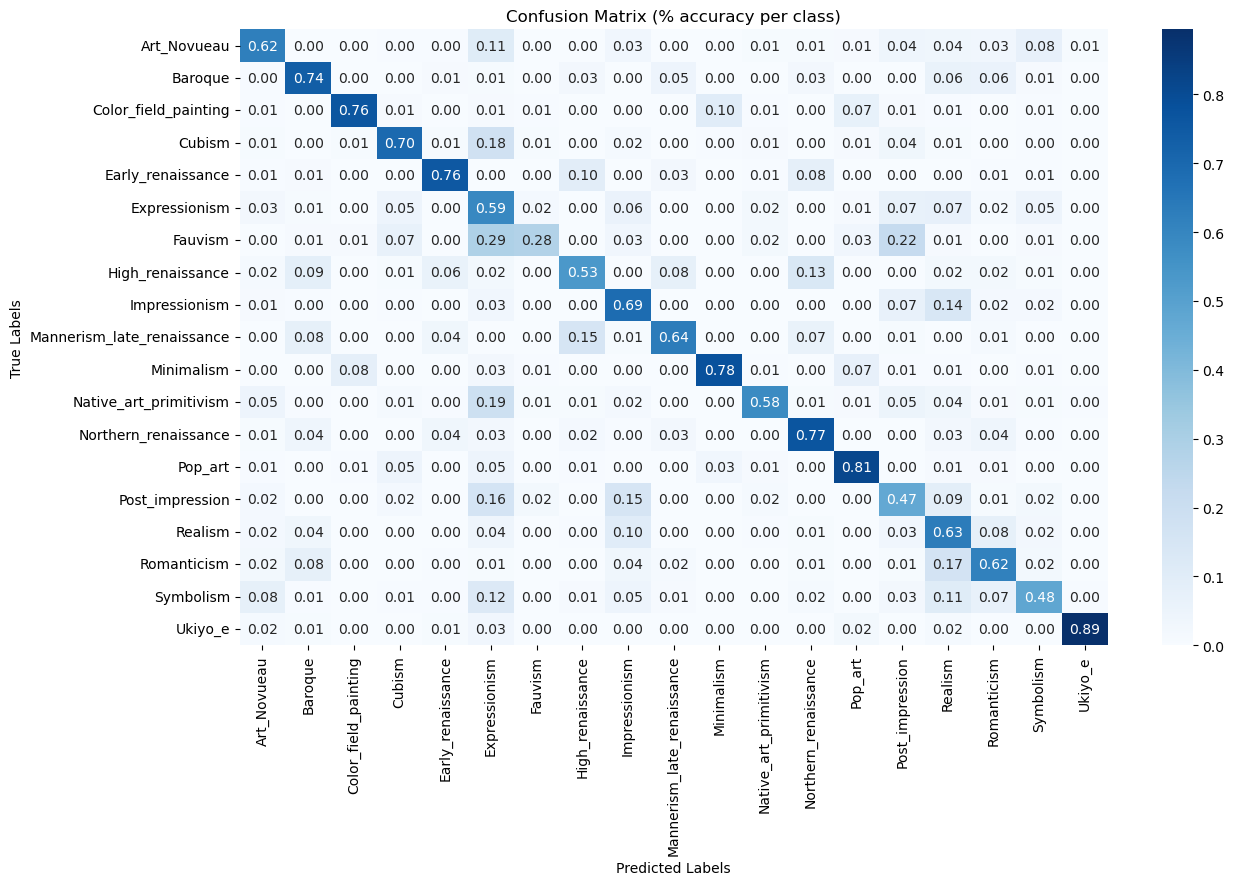

                            precision    recall  f1-score   support

               Art_Novueau       0.64      0.62      0.63       413
                   Baroque       0.67      0.74      0.70       418
      Color_field_painting       0.89      0.76      0.82       182
                    Cubism       0.71      0.70      0.70       261
         Early_renaissance       0.73      0.76      0.74       157
             Expressionism       0.47      0.59      0.52       659
                   Fauvism       0.40      0.28      0.33        89
          High_renaissance       0.49      0.53      0.51       126
             Impressionism       0.73      0.69      0.71      1314
Mannerism_late_renaissance       0.58      0.64      0.61       137
                Minimalism       0.82      0.78      0.80       147
    Native_art_primitivism       0.76      0.58      0.66       278
      Northern_renaissance       0.69      0.77      0.73       240
                   Pop_art       0.70      0.81

In [5]:
# Path to saved model
model_path = "C:\\Users\\PRANAV\\Downloads\\Model1_c.h5"
model = load_model(model_path)

# Assuming test data is in a directory 'test_data_directory'
test_data_directory = "D:\\Wikiart_splitted\\test"

batch_size = 32
image_height = 299
image_width = 299

# ImageDataGenerator for preprocessing and loading test images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(image_height, image_width), 
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class labels from the generator

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (% accuracy per class)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))